In [6]:
# Import required libraries
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import yfinance as yf
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import custom modules
from models.volatility import VolatilityAnalyzer
from models.risk_metrics import RiskAnalyzer
from data.data_loader import MarketDataLoader

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

In [7]:
# Define symbols and timeframe
symbols = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2020-01-01'
end_date = '2024-02-17'

# Load data
data_loader = MarketDataLoader(symbols, start_date, end_date)
market_data = data_loader.fetch_data()

# Display basic statistics
for symbol in symbols:
    print(f"\nSummary Statistics for {symbol}:")
    print(market_data[symbol]['Returns'].describe())

2025-02-17 17:00:37.020 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 17:00:37.086 
  command:

    streamlit run /Users/muntazirabidi/miniconda3/envs/ai_learning/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-02-17 17:00:37.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 17:00:37.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 17:00:37.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 17:00:37.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 17:00:37.088 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-17 1


Summary Statistics for AAPL:
count    1038.000000
mean        0.001100
std         0.020935
min        -0.128647
25%        -0.009081
50%         0.000725
75%         0.012587
max         0.119809
Name: Returns, dtype: float64

Summary Statistics for MSFT:
count    1038.000000
mean        0.001133
std         0.020326
min        -0.147390
25%        -0.009149
50%         0.001047
75%         0.012017
max         0.142169
Name: Returns, dtype: float64

Summary Statistics for GOOGL:
count    1038.000000
mean        0.000915
std         0.021026
min        -0.116342
25%        -0.009595
50%         0.001141
75%         0.011607
max         0.092412
Name: Returns, dtype: float64


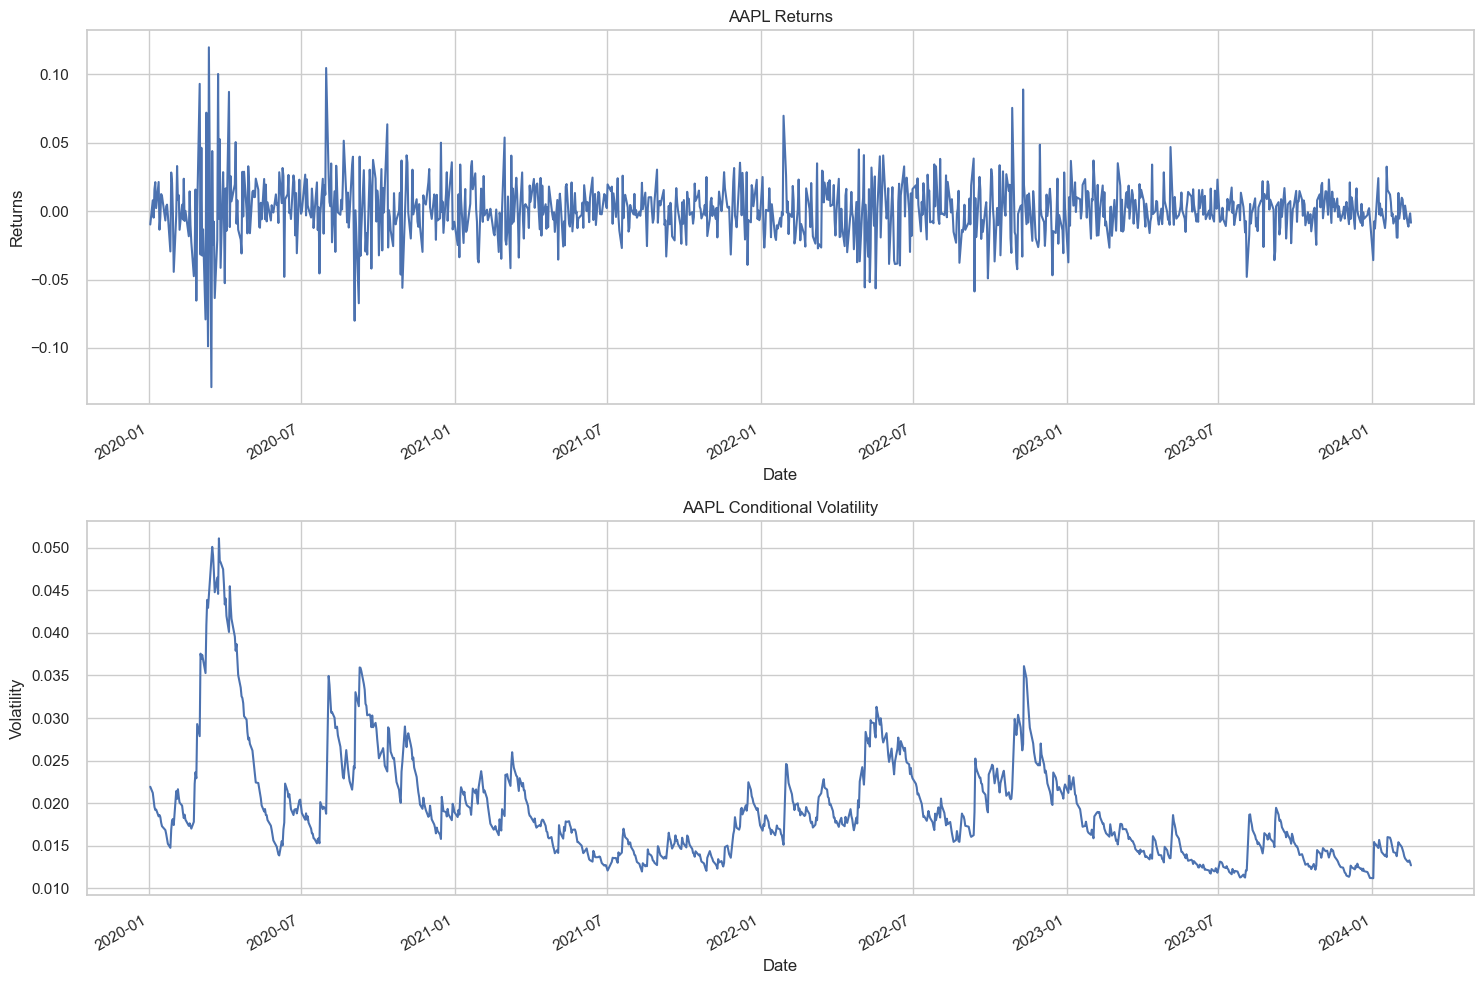

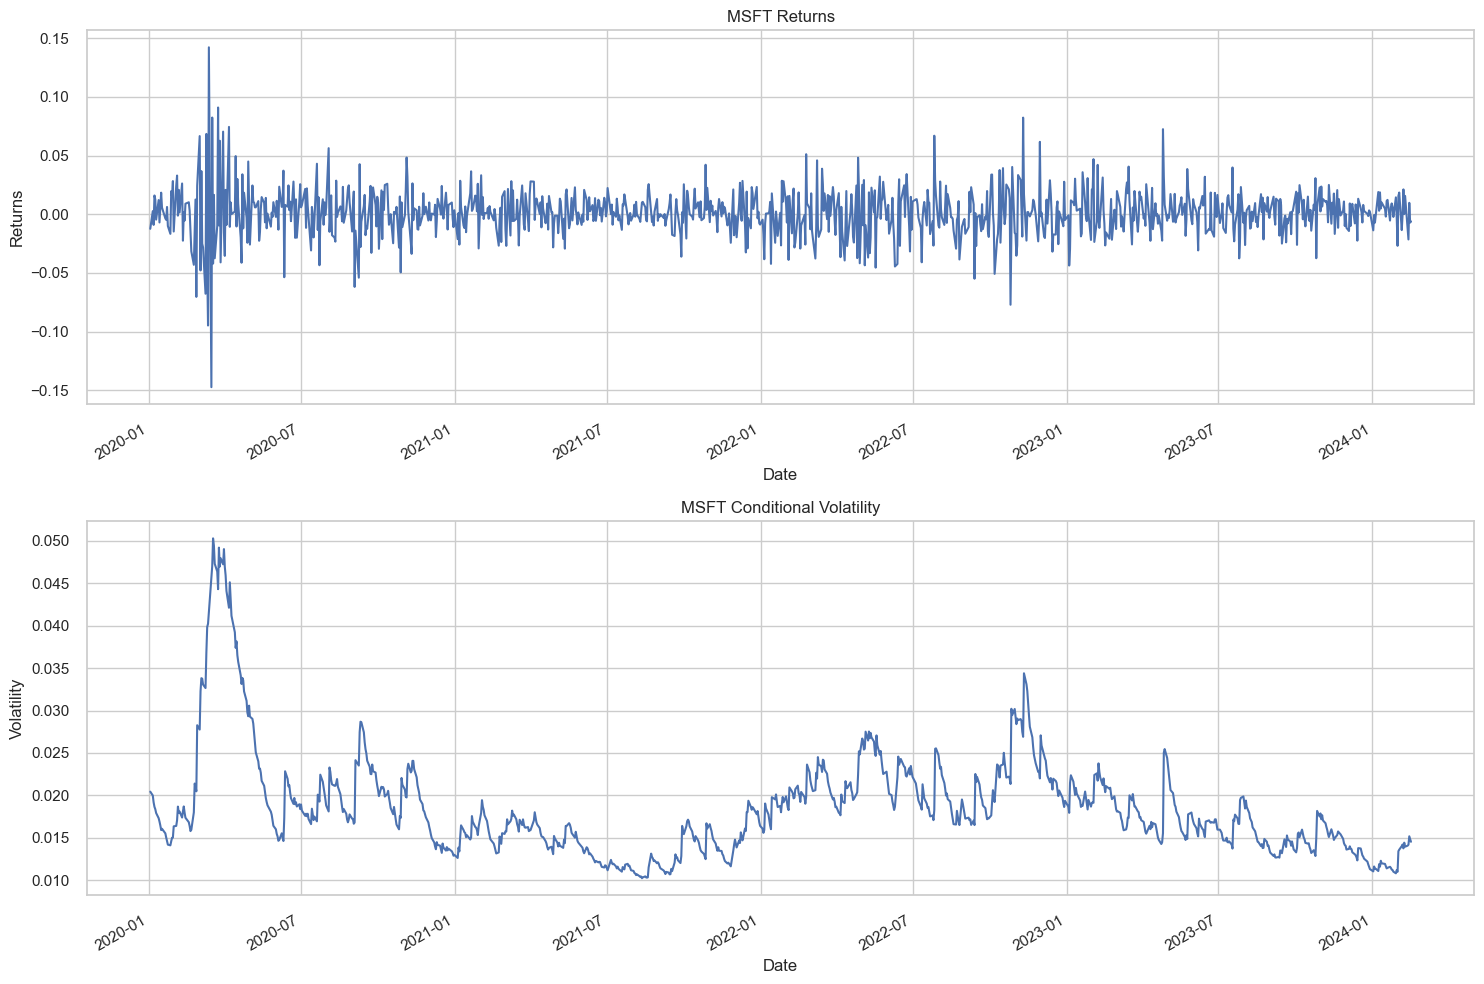

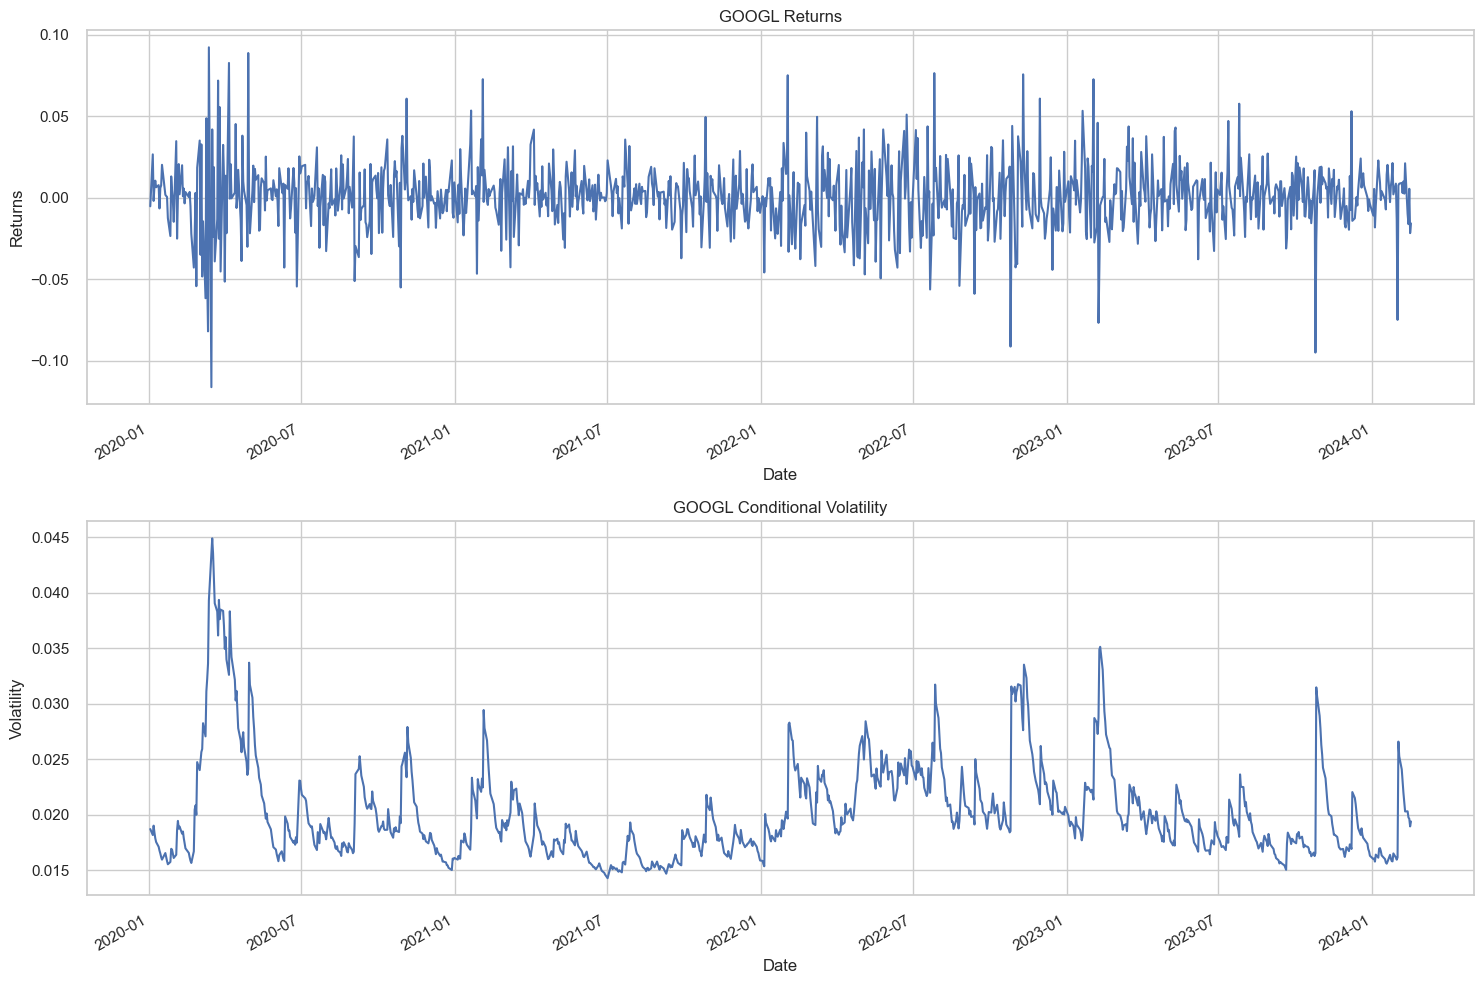

In [8]:
def analyze_volatility(symbol, data):
    """Perform comprehensive volatility analysis for a symbol"""
    returns = data['Returns'].dropna()
    
    # Initialize analyzer
    vol_analyzer = VolatilityAnalyzer(returns)
    vol_analyzer.fit_garch()
    
    # Plot returns and volatility
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Returns plot
    returns.plot(ax=ax1, title=f'{symbol} Returns')
    ax1.set_ylabel('Returns')
    
    # Volatility plot
    vol_analyzer.volatility.plot(ax=ax2, title=f'{symbol} Conditional Volatility')
    ax2.set_ylabel('Volatility')
    
    plt.tight_layout()
    
    return vol_analyzer

# Analyze each symbol
analyzers = {}
for symbol in symbols:
    analyzers[symbol] = analyze_volatility(symbol, market_data[symbol])

In [9]:
def plot_regime_analysis(symbol, analyzer):
    """Plot regime analysis for a symbol"""
    # Get regime information
    regime = analyzer.detect_regime()
    clusters = analyzer.calculate_clusters()
    
    # Create figure
    fig = make_subplots(
        rows=2, 
        cols=2,
        subplot_titles=(
            'Volatility and Regimes',
            'Volatility Distribution',
            'Autocorrelation of Squared Returns',
            'QQ Plot'
        )
    )
    
    # Plot 1: Volatility with regime highlighting
    fig.add_trace(
        go.Scatter(
            x=analyzer.volatility.index,
            y=analyzer.volatility,
            name='Volatility'
        ),
        row=1, col=1
    )
    
    # Highlight regimes
    colors = {
        'high_volatility': 'rgba(255,0,0,0.3)',
        'low_volatility': 'rgba(0,255,0,0.3)',
        'normal_volatility': 'rgba(0,0,255,0.3)'
    }
    
    for cluster_name, cluster_mask in clusters.items():
        if cluster_mask.any():
            cluster_data = analyzer.volatility[cluster_mask]
            fig.add_trace(
                go.Scatter(
                    x=cluster_data.index,
                    y=cluster_data,
                    name=cluster_name,
                    mode='markers',
                    marker=dict(color=colors[cluster_name])
                ),
                row=1, col=1
            )
    
    # Plot 2: Volatility distribution
    fig.add_trace(
        go.Histogram(
            x=analyzer.volatility,
            name='Volatility Distribution',
            nbinsx=50
        ),
        row=1, col=2
    )
    
    # Plot 3: ACF of squared returns
    from statsmodels.tsa.stattools import acf
    squared_returns = analyzer.returns**2
    acf_values = acf(squared_returns, nlags=20)
    
    fig.add_trace(
        go.Bar(
            x=list(range(len(acf_values))),
            y=acf_values,
            name='ACF of Squared Returns'
        ),
        row=2, col=1
    )
    
    # Plot 4: QQ plot
    from scipy import stats
    theoretical_quantiles = np.linspace(0.01, 0.99, 100)
    empirical_quantiles = np.percentile(analyzer.returns, theoretical_quantiles * 100)
    
    fig.add_trace(
        go.Scatter(
            x=stats.norm.ppf(theoretical_quantiles),
            y=empirical_quantiles,
            mode='markers',
            name='QQ Plot'
        ),
        row=2, col=2
    )
    
    # Add reference line for QQ plot
    min_val = stats.norm.ppf(0.01)
    max_val = stats.norm.ppf(0.99)
    fig.add_trace(
        go.Scatter(
            x=[min_val, max_val],
            y=[min_val, max_val],
            mode='lines',
            line=dict(dash='dash'),
            name='Normal Reference'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        title=f'Volatility Analysis for {symbol}',
        showlegend=True,
        template='plotly_white'
    )
    
    # Update axes labels
    fig.update_xaxes(title_text='Date', row=1, col=1)
    fig.update_xaxes(title_text='Volatility', row=1, col=2)
    fig.update_xaxes(title_text='Lag', row=2, col=1)
    fig.update_xaxes(title_text='Theoretical Quantiles', row=2, col=2)
    
    fig.update_yaxes(title_text='Volatility', row=1, col=1)
    fig.update_yaxes(title_text='Frequency', row=1, col=2)
    fig.update_yaxes(title_text='ACF', row=2, col=1)
    fig.update_yaxes(title_text='Empirical Quantiles', row=2, col=2)
    
    return fig

# Plot regime analysis for each symbol
for symbol, analyzer in analyzers.items():
    fig = plot_regime_analysis(symbol, analyzer)
    fig.show()

In [12]:
def analyze_risk_metrics(symbol, analyzer):
    """Analyze and plot risk metrics"""
    # Calculate forecasts
    forecast = analyzer.forecast_volatility(horizon=10)
    
    # Calculate VaR and ES
    risk_analyzer = RiskAnalyzer(analyzer.returns, analyzer.volatility)
    var_95 = risk_analyzer.calculate_var(confidence=0.95)
    es_95 = risk_analyzer.calculate_expected_shortfall(confidence=0.95)
    
    # Create summary table
    summary = pd.DataFrame({
        'Metric': ['Current Volatility', 'Forecast (10-day)', 'VaR (95%)', 'ES (95%)'],
        'Value': [
            f"{analyzer.volatility.iloc[-1]:.2%}",
            f"{forecast.mean():.2%}",
            f"{var_95:.2%}",
            f"{es_95:.2%}"
        ]
    })
    
    return summary

# Analyze risk metrics for each symbol
for symbol, analyzer in analyzers.items():
    print(f"\nRisk Analysis for {symbol}:")
    summary = analyze_risk_metrics(symbol, analyzer)
    display(summary)


Risk Analysis for AAPL:


,Metric,Value
0,Current Volatility,1.27%
1,Forecast (10-day),135.29%
2,VaR (95%),-2.09%
3,ES (95%),0.38%



Risk Analysis for MSFT:


,Metric,Value
0,Current Volatility,1.45%
1,Forecast (10-day),146.77%
2,VaR (95%),-2.39%
3,ES (95%),0.24%



Risk Analysis for GOOGL:


,Metric,Value
0,Current Volatility,1.94%
1,Forecast (10-day),196.03%
2,VaR (95%),-3.19%
3,ES (95%),0.17%


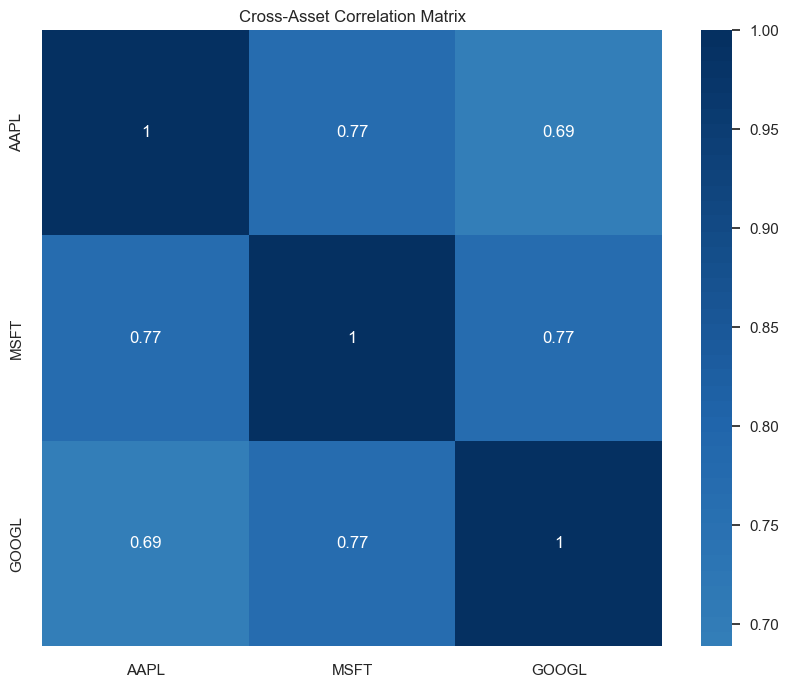

KeyError: 'AAPL'

<Figure size 1500x500 with 0 Axes>

In [13]:
def analyze_cross_asset_relationships():
    """Analyze relationships between assets"""
    # Create returns DataFrame
    returns_df = pd.DataFrame({
        symbol: market_data[symbol]['Returns'] 
        for symbol in symbols
    })
    
    # Calculate correlation matrix
    corr_matrix = returns_df.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='RdBu',
        center=0
    )
    plt.title('Cross-Asset Correlation Matrix')
    plt.show()
    
    # Calculate rolling correlations
    window = 63  # ~3 months
    rolling_corr = returns_df.rolling(window=window).corr()
    
    # Plot rolling correlations
    plt.figure(figsize=(15, 5))
    for i, sym1 in enumerate(symbols):
        for j, sym2 in enumerate(symbols):
            if i < j:
                rolling_corr_pair = rolling_corr.xs(
                    key=sym1
                )[sym2].dropna()
                rolling_corr_pair.plot(
                    label=f'{sym1} vs {sym2}'
                )
    
    plt.title('Rolling Correlations (63-day window)')
    plt.legend()
    plt.show()

# Perform cross-asset analysis
analyze_cross_asset_relationships()

In [14]:
def calculate_trading_signals():
    """Calculate trading signals based on volatility regimes"""
    signals = pd.DataFrame()
    
    for symbol, analyzer in analyzers.items():
        # Get volatility regime
        regime = analyzer.detect_regime()
        
        # Calculate position sizes
        base_position = 100000  # $100k base position
        adjusted_position = base_position * regime.risk_factor
        
        # Calculate stop distances
        base_stop = 0.02  # 2% base stop
        adjusted_stop = base_stop * (1/regime.risk_factor)
        
        signals[symbol] = pd.Series({
            'Regime': regime.regime,
            'Risk Factor': regime.risk_factor,
            'Position Size': f"${adjusted_position:,.0f}",
            'Stop Distance': f"{adjusted_stop:.2%}"
        })
    
    return signals.T

# Calculate and display trading signals
signals = calculate_trading_signals()
display(signals)

,Regime,Risk Factor,Position Size,Stop Distance
AAPL,Low Volatility,1.2,"$120,000",1.67%
MSFT,Normal Volatility,1.0,"$100,000",2.00%
GOOGL,Normal Volatility,1.0,"$100,000",2.00%
